- get `rna` data from processed rds file : has raw counts
- get `atac` data from provided matrix file : no raw counts and no peak information

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import muon as mu
from muon import atac as ac
import pandas as pd
import numpy as np

raw_path = '../../data/wang2024_SA/processed'

In [2]:
adata = sc.read_h5ad("/home/jiehoonk/project/crisprscreen/data/wang2024_SA/h5ad/SCSP0000482_snRNA.h5ad")
adata

AnnData object with n_obs × n_vars = 90504 × 39253
    obs: 'cell_type', 'sub_celltype', 'sample_name', 'patient_name'
    obsm: 'X_umap'

In [4]:
adata.obs.sample_name.value_counts()

sample_name
P1N21    16323
P3N21    16027
P3TC1    12626
P1TC1    11712
P4N21     8894
P5TC1     7803
P4TC1     7072
P5N21     5310
O1N21     2483
O1TC1     2254
Name: count, dtype: int64

In [5]:
def load_data(path, assay = 'RNA'):
    barcodes = pd.read_csv(os.path.join(path, f'Barcodes_file_sn{assay}.txt'), index_col=0, header=None).rename_axis(None)
    features = pd.read_csv(os.path.join(path, f'Genes_file_sn{assay}.txt'), index_col=0, header=None, sep = '\t').rename_axis(None).rename(columns={1: 'gene_symbol'})
    metadata = pd.read_csv(os.path.join(path, f'Metadata_file_sn{assay}.txt'), index_col=0, sep = '\t', skiprows = 1).rename_axis(None).rename(columns={'group':'cell_type', 'group.1': 'cluster', 'sample_attribute' : 'sample_id', 'patient_attribute' : 'patient_id'})
    len(barcodes), len(features), len(metadata)
    adata = sc.read_mtx(os.path.join(path, f'MM_coordinate_matrix_file_sn{assay}.txt')).T
    adata.obs.index = barcodes.index
    adata.var.index = features.index
    adata.obs = adata.obs.join(metadata)
    adata.obs['barcode'] = adata.obs.index
    embedding = pd.read_csv(os.path.join(path, f'Cluster_file_sn{assay}.txt'), index_col=0, sep = '\t', skiprows = 1).rename_axis(None).rename(columns={'numeric': 'X', 'numeric.1': 'Y'})

    if assay == "ATAC":
        adata.obs.index = adata.obs.barcode.apply(lambda x:x.split('#', 1)[1]).rename(None, inplace=True)
    else:
        adata.obs.index = adata.obs.barcode.apply(lambda x:x.split('_', 1)[1]).rename(None, inplace=True)
    embedding.index = adata.obs.index
    adata.obsm['X_umap'] = embedding
    return adata

In [1]:
atac = load_data(raw_path, 'ATAC')

NameError: name 'load_data' is not defined

In [ ]:
atac.obs.patient_id.value_counts()

In [185]:
rna = load_data(raw_path, 'RNA')

In [179]:
mdata = mu.MuData({"rna" : rna, "atac" : atac})
mdata

MuData object with n_obs × n_vars = 191069 × 64172
  2 modalities
    rna:	90504 x 39253
      obs:	'cell_type', 'cluster', 'sample_id', 'patient_id', 'barcode'
      obsm:	'X_umap'
    atac:	100565 x 24919
      obs:	'cell_type', 'cluster', 'sample_id', 'patient_id', 'barcode'
      obsm:	'X_umap'

In [ ]:
atac.obs.

Index([], dtype='object')

In [191]:
rna.obs

,cell_type,cluster,sample_id,patient_id,barcode
O1N21R1_TTCCTCATAGCTATGTCGCG,Myeloid,7,O1N21,O1,O1N21R1_O1N21R1_TTCCTCATAGCTATGTCGCG
O1N21R1_TAATATTCAGTATCTACACA,Undefined,13,O1N21,O1,O1N21R1_O1N21R1_TAATATTCAGTATCTACACA
O1N21R1_GCGTATGCGGTAACATTGTG,Excitatory neuron,16,O1N21,O1,O1N21R1_O1N21R1_GCGTATGCGGTAACATTGTG
O1N21R1_GACTCACTGACACGCTCTCT,Excitatory neuron,16,O1N21,O1,O1N21R1_O1N21R1_GACTCACTGACACGCTCTCT
O1N21R1_CGATTGCGCGACGATTACCA,Inhibitory neuron,10,O1N21,O1,O1N21R1_O1N21R1_CGATTGCGCGACGATTACCA
...,...,...,...,...,...
P5TC1R2_CELL6032_N1,Oligodendrocyte,15,P5TC1,P5,P5TC1R2_P5TC1R2_CELL6032_N1
P5TC1R2_CELL5907_N1,Pericyte/Endothelial cell,18,P5TC1,P5,P5TC1R2_P5TC1R2_CELL5907_N1
P5TC1R2_CELL5619_N1,GBM cell,4,P5TC1,P5,P5TC1R2_P5TC1R2_CELL5619_N1
P5TC1R2_CELL5898_N1,GBM cell,4,P5TC1,P5,P5TC1R2_P5TC1R2_CELL5898_N1


In [181]:
mu.pp.intersect_obs(mdata)

ValueError: value.index does not match parent’s obs names:
Index are different

Attribute "inferred_type" are different
[left]:  string
[right]: empty

In [68]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

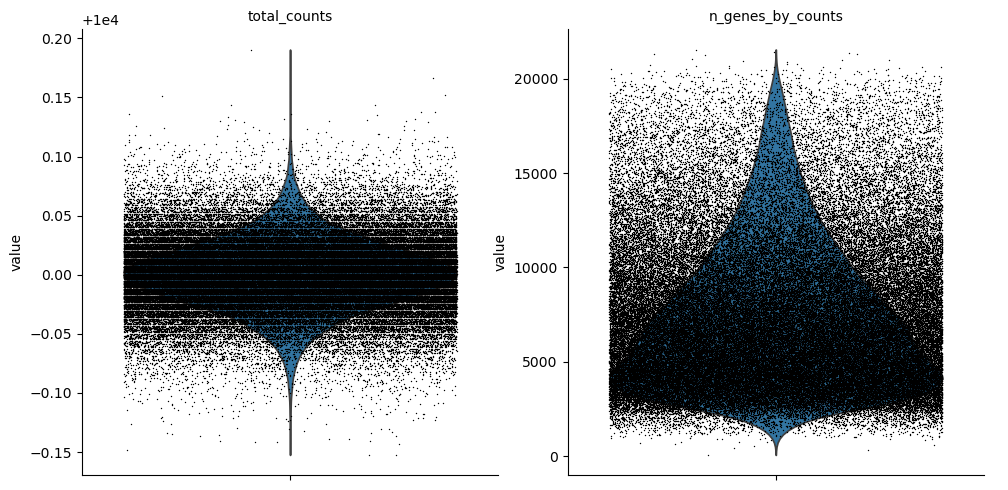

In [70]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)